In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

# Data Loading and Preprocessing

In [14]:
df_1 = pd.read_csv('dataset/test.csv')
df_1['char_count'] = df_1['Description'].apply(len)
df_1 = df_1[df_1['Class Index'] != 4]

class_counts = df_1['Class Index'].value_counts()

# Randomly selecting 100 instances from each class
df = pd.DataFrame()

for class_index in class_counts.index:
    class_df = df_1[df_1['Class Index'] == class_index]
    
    selected_df = class_df.head(50)
    df = pd.concat([df, selected_df], ignore_index=True)

df = df.drop(columns=['Title'])
df = df.drop(columns=['char_count'])
df['ID'] = range(1, len(df) + 1)
df['Description'] = df['Description'].str.strip()
df['Description'] = df['Description'].str.replace(r'[^A-Za-z0-9\s]', '')
df['Description'] = df['Description'].str.lower()

df.head()

C:\Users\91900\AppData\Local\Temp\ipykernel_3116\1092364935.py:22: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Description'] = df['Description'].str.replace(r'[^A-Za-z0-9\s]', '')


,Class Index,Description,ID
0,3,unions representing workers at turner newall...,1
1,3,reuters apparel retailers are hoping theirbac...,2
2,3,london reuters the dollar dipped to a fourwee...,3
3,3,new york reuters us treasury debt prices slip...,4
4,3,new york reuters the dollar extended gains ag...,5


In [15]:
df.describe()

,Class Index,ID
count,150.000000,150.000000
mean,2.000000,75.500000
std,0.819232,43.445368
min,1.000000,1.000000
25%,1.000000,38.250000
50%,2.000000,75.500000
75%,3.000000,112.750000
max,3.000000,150.000000


# Plot for number of documents in each category

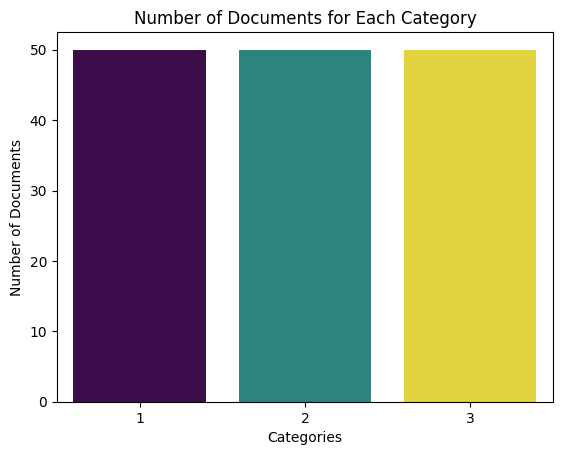

In [16]:
counts = df['Class Index'].value_counts()
sns.barplot(x=counts.index, y=counts.values, hue = counts.index, legend = False, palette='viridis')
plt.xlabel('Categories')
plt.ylabel('Number of Documents')
plt.title('Number of Documents for Each Category')
plt.show()

# Shingles

In [17]:
def create_word_shingles(df, k=10):
    shingles = set()
    for index, row in df.iterrows():
        description = row['Description']
        description = description.split()
        for i in range(len(description) - k + 1):
            shingle = description[i:i+k]
            shingles.add(' '.join(description[i:i+k]))    
    return shingles

def shingles_per_row(text, k):
    shingle = set()
    text = text.split()
    for i in range(len(text) - k + 1):
        shingle.add(' '.join(text[i:i + k]))
    return set(shingle)

In [18]:
df['shingles5'] = df['Description'].apply(lambda x: shingles_per_row(x, 5))
df['shingles10'] = df['Description'].apply(lambda x: shingles_per_row(x, 10))
df['shingles8'] = df['Description'].apply(lambda x: shingles_per_row(x, 8))

# Creating shingle matrices for different k

In [19]:
def create_shingles_final(df):

    shingles_5 = create_word_shingles(df, 5)
    shingles_8 = create_word_shingles(df, 8)
    shingles_10 = create_word_shingles(df, 10)

    shingle_5_matrix = np.zeros((len(shingles_5), len(df)))
    shingle_8_matrix = np.zeros((len(shingles_8), len(df)))
    shingle_10_matrix = np.zeros((len(shingles_10), len(df)))

    for i, s in enumerate(shingles_5):
        for j in range(len(df)):
            if s in df['shingles5'][j]:
                shingle_5_matrix[i, j] = 1

    for i, s in enumerate(shingles_8):
        for j in range(len(df)):
            if s in df['shingles8'][j]:
                shingle_8_matrix[i, j] = 1

    for i, s in enumerate(shingles_10):
        for j in range(len(df)):
            if s in df['shingles10'][j]:
                shingle_10_matrix[i, j] = 1

    shingle_5_df = pd.DataFrame(shingle_5_matrix, index= list(shingles_5), columns=df.index)
    shingle_8_df = pd.DataFrame(shingle_8_matrix, index= list(shingles_8), columns=df.index)
    shingle_10_df = pd.DataFrame(shingle_10_matrix, index= list(shingles_10), columns=df.index)
    
    return shingle_5_df, shingle_8_df, shingle_10_df

In [20]:
word_shingle_5_df, word_shingle_8_df, word_shingle_10_df = create_shingles_final(df)

In [21]:
print(word_shingle_5_df.shape)
print(word_shingle_8_df.shape)
print(word_shingle_10_df.shape)

(4162, 150)
(3731, 150)
(3437, 150)


# Min Hashing

In [22]:
def min_hashing(shingle_df, percentage):
    # Number of hash functions
    num_hash_functions = int(shingle_df.shape[0] * percentage)
    hash_functions = [(np.random.randint(1, 100), np.random.randint(1, 100)) for _ in range(num_hash_functions)]
    signature_matrix = pd.DataFrame(np.inf, index=range(1, num_hash_functions + 1), columns=shingle_df.columns.difference(['Shingle']))
    shingle_index_map = {shingle: idx for idx, shingle in enumerate(shingle_df.index)}

    for index, row in shingle_df.iterrows():
        for col in shingle_df.columns:
            if row[col] == 1:
                for i, (a, b) in enumerate(hash_functions, start=1):
                    hash_value = (a * shingle_index_map[index] + b) % shingle_df.shape[0]
                    signature_matrix.loc[i, col] = min(signature_matrix.loc[i, col], hash_value)

    return signature_matrix

# Signature Matrices using Min Hashing

In [23]:
def compute_signatures_matrices(shingle_5_df, shingle_8_df, shingle_10_df, percentage):

    signature_matrix_5 = min_hashing(shingle_5_df, percentage)
    signature_matrix_8 = min_hashing(shingle_8_df, percentage)
    signature_matrix_10 = min_hashing(shingle_10_df, percentage)
    
    return signature_matrix_5, signature_matrix_8, signature_matrix_10

In [24]:
signature_matrix_5_10, signature_matrix_8_10, signature_matrix_10_10 = compute_signatures_matrices(word_shingle_5_df, word_shingle_8_df, word_shingle_10_df, 0.1)

# # store the signature matrix in a csv file
# signature_matrix_5_10.to_csv('word_signature_matrix_5_10.csv')
# signature_matrix_8_10.to_csv('word_signature_matrix_8_10.csv')
# signature_matrix_10_10.to_csv('word_signature_matrix_10_10.csv')

In [25]:
signature_matrix_5_20, signature_matrix_8_20, signature_matrix_10_20 = compute_signatures_matrices(word_shingle_5_df, word_shingle_8_df, word_shingle_10_df, 0.2)

# # store the signature matrix in a csv file
# signature_matrix_5_20.to_csv('word_signature_matrix_5_20.csv')
# signature_matrix_8_20.to_csv('word_signature_matrix_8_20.csv')
# signature_matrix_10_20.to_csv('word_signature_matrix_10_20.csv')

In [26]:
signature_matrix_5_30, signature_matrix_8_30, signature_matrix_10_30 = compute_signatures_matrices(word_shingle_5_df, word_shingle_8_df, word_shingle_10_df, 0.3)

# # store the signature matrix in a csv file
# signature_matrix_5_30.to_csv('word_signature_matrix_5_30.csv')
# signature_matrix_8_30.to_csv('word_signature_matrix_8_30.csv')
# signature_matrix_10_30.to_csv('word_signature_matrix_10_30.csv')

# Jaccard Similarity

In [27]:
def jaccard_similarity(signature_matrix, i, j):
    return np.sum(signature_matrix.loc[:, i] == signature_matrix.loc[:, j]) / np.sum(signature_matrix.loc[:, i])

In [28]:
def jaccard_similarity_column_numpy(shingle_df, i, j):
    
    intersection = np.sum((shingle_df[:, i] == shingle_df[:, j]) & (shingle_df[:, i] == 1))
    union = np.sum((shingle_df[:, i] == 1) | (shingle_df[:, j] == 1))

    if union == 0:
        return 0.0  # Avoid division by zero

    return intersection / union

In [39]:
def plot_jaccard_similarity(numsize, sign_mat_5, sign_mat_8, sign_mat_10, classid, shingle_5_df, shingle_8_df, shingle_10_df):

    if classid == 1:
        random_numbers = np.random.choice(range(50), numsize, replace=False)
    elif classid == 2:
        random_numbers = np.random.choice(range(50, 100), numsize, replace=False)
    elif classid == 3:
        random_numbers = np.random.choice(range(100, 150), numsize, replace=False)
    else:
        random_numbers = np.random.choice(range(150), numsize, replace=False)

    jaccard_similarity_5 = np.zeros((numsize, numsize))
    jaccard_similarity_8 = np.zeros((numsize, numsize))
    jaccard_similarity_10 = np.zeros((numsize, numsize))
    column_similarity_5 = np.zeros((numsize, numsize))
    column_similarity_8 = np.zeros((numsize, numsize))
    column_similarity_10 = np.zeros((numsize, numsize))

    for i in range(numsize):
        for j in range(numsize):
            if i != j:
                num1 = random_numbers[i]
                num2 = random_numbers[j]
                jaccard_similarity_5[i, j] = jaccard_similarity(sign_mat_5, num1, num2)
                jaccard_similarity_8[i, j] = jaccard_similarity(sign_mat_8, num1, num2)
                jaccard_similarity_10[i, j] = jaccard_similarity(sign_mat_10, num1, num2)
                column_similarity_5[i, j] = jaccard_similarity_column_numpy(shingle_5_df.to_numpy(), num1, num2)
                column_similarity_8[i, j] = jaccard_similarity_column_numpy(shingle_8_df.to_numpy(), num1, num2)
                column_similarity_10[i, j] = jaccard_similarity_column_numpy(shingle_10_df.to_numpy(), num1, num2)

    
    jaccard_similarity_5 = jaccard_similarity_5.flatten()
    jaccard_similarity_8 = jaccard_similarity_8.flatten()
    jaccard_similarity_10 = jaccard_similarity_10.flatten()
    column_similarity_5 = column_similarity_5.flatten()
    column_similarity_8 = column_similarity_8.flatten()
    column_similarity_10 = column_similarity_10.flatten()

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

    axes[0].plot(jaccard_similarity_5, label='Jaccard Similarity (k = 5)')
    axes[0].plot(column_similarity_5, label='Column Similarity (k = 5)')
    axes[0].legend()

    axes[1].plot(jaccard_similarity_8, label='Jaccard Similarity (k = 8)')
    axes[1].plot(column_similarity_8, label='Column Similarity (k = 8)')
    axes[1].legend()

    axes[2].plot(jaccard_similarity_10, label='Jaccard Similarity (k = 10)')
    axes[2].plot(column_similarity_10, label='Column Similarity (k = 10)')
    axes[2].legend()

    plt.show()

# Analysis of similarity using Jaccard cofficient for all news

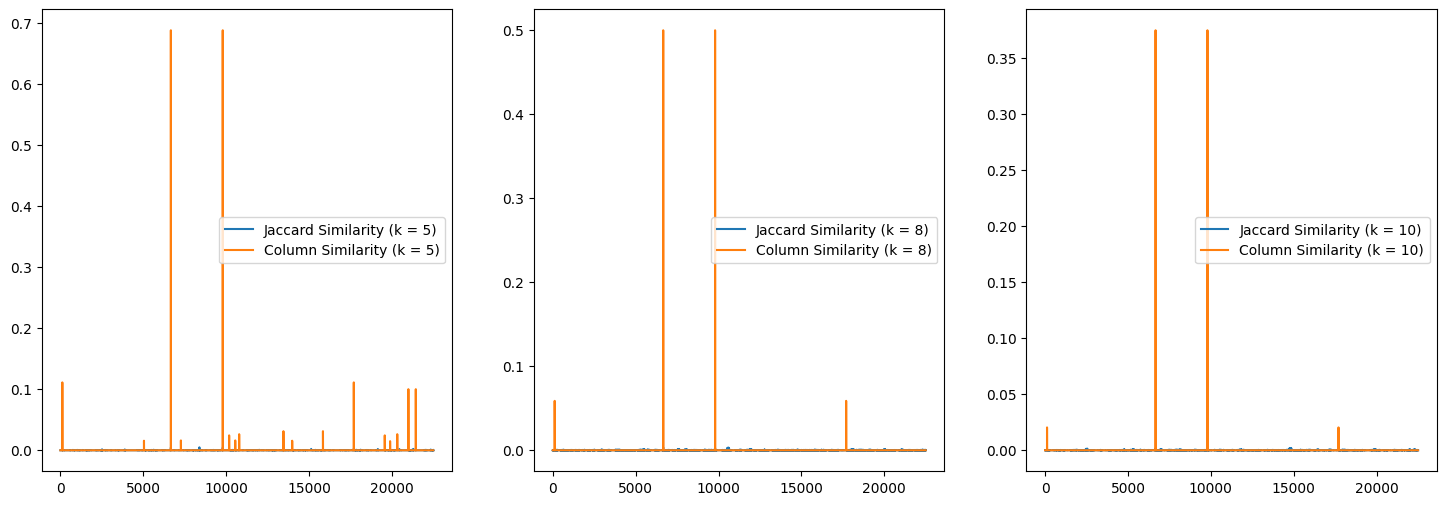

In [41]:
plot_jaccard_similarity(150, signature_matrix_5_10, signature_matrix_8_10, signature_matrix_10_10, 4, word_shingle_5_df, word_shingle_8_df, word_shingle_10_df) #10

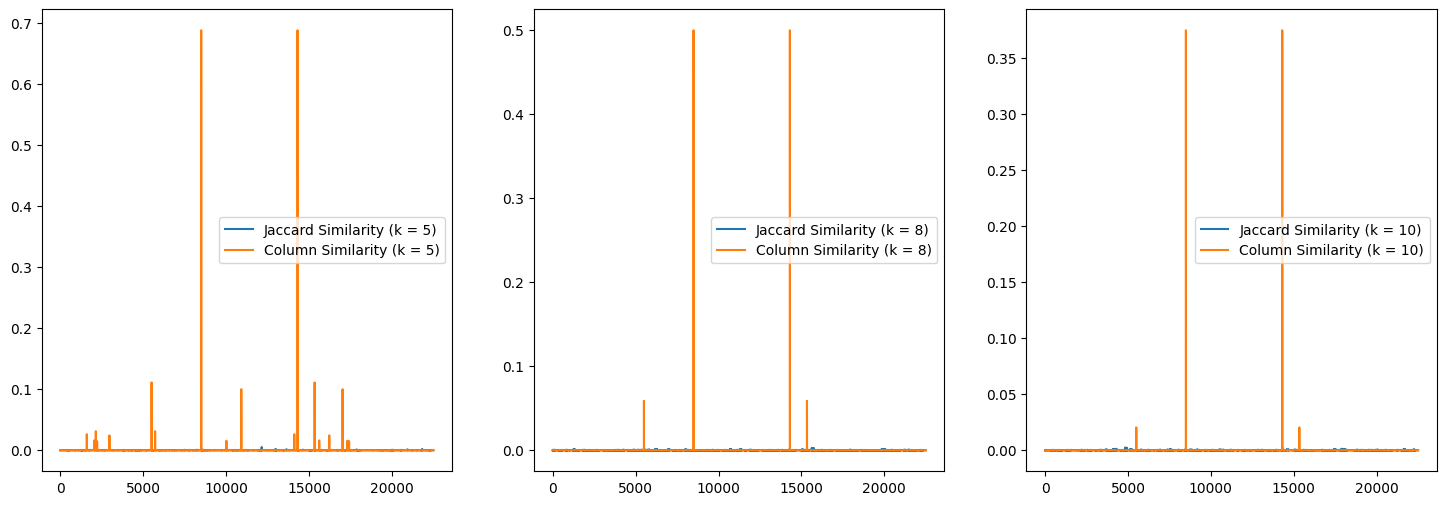

In [43]:
plot_jaccard_similarity(150, signature_matrix_5_20, signature_matrix_8_20, signature_matrix_10_20, 4, word_shingle_5_df, word_shingle_8_df, word_shingle_10_df)

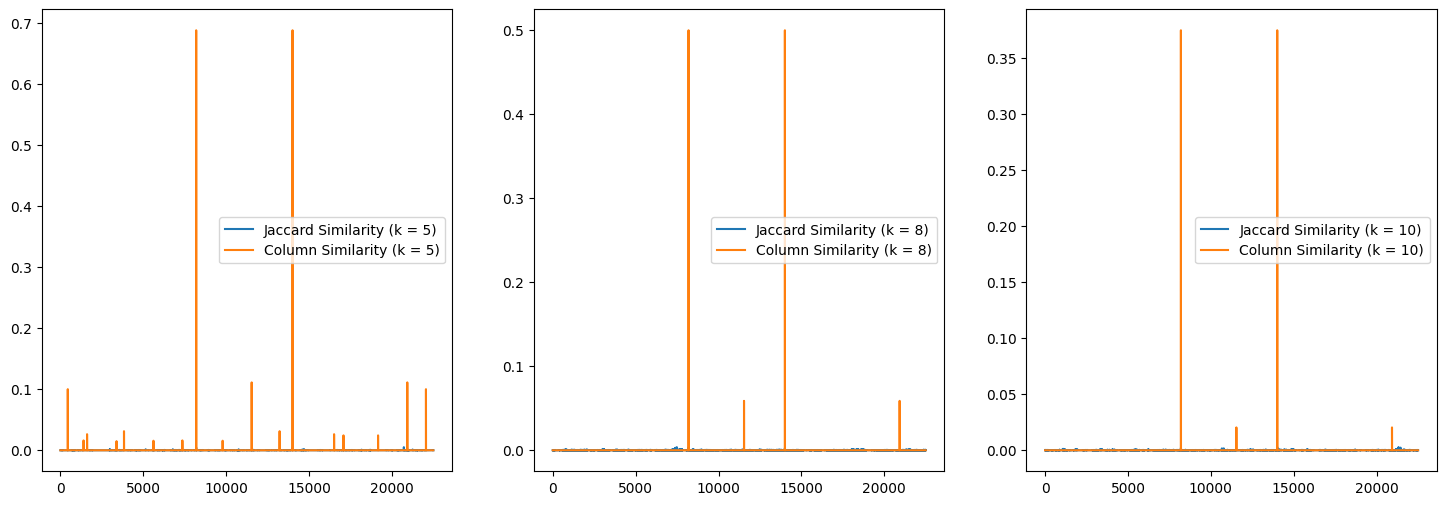

In [44]:
plot_jaccard_similarity(150, signature_matrix_5_30, signature_matrix_8_30, signature_matrix_10_30, 4, word_shingle_5_df, word_shingle_8_df, word_shingle_10_df)

# Dice Similarity

In [46]:
def dice_similarity_column(shingle_df, i, j):
    intersection = np.sum((shingle_df[:, i] == shingle_df[:, j]) & (shingle_df[:, i] == 1))
    union = np.sum(shingle_df[:, i] == 1) + np.sum(shingle_df[:, j] == 1)

    if union == 0:
        return 0.0  # Avoid division by zero

    return 2 * intersection / union

def dice_similarity(signature_matrix, i, j):
    return 2 * np.sum(signature_matrix.loc[:, i] == signature_matrix.loc[:, j]) / (np.sum(signature_matrix.loc[:, i]) + np.sum(signature_matrix.loc[:, j]))

In [47]:
def plot_dice_similarity(numsize, sign_mat_5, sign_mat_8, sign_mat_10, classid, shingle_5_df, shingle_8_df, shingle_10_df):

    if classid == 1:
        random_numbers = np.random.choice(range(50), numsize, replace=False)
    elif classid == 2:
        random_numbers = np.random.choice(range(50, 100), numsize, replace=False)
    elif classid == 3:
        random_numbers = np.random.choice(range(100, 150), numsize, replace=False)
    else:
        random_numbers = np.random.choice(range(150), numsize, replace=False)

    dice_similarity_5 = np.zeros((numsize, numsize))
    dice_similarity_8 = np.zeros((numsize, numsize))
    dice_similarity_10 = np.zeros((numsize, numsize))
    column_similarity_5 = np.zeros((numsize, numsize))
    column_similarity_8 = np.zeros((numsize, numsize))
    column_similarity_10 = np.zeros((numsize, numsize))

    for i in range(numsize):
        for j in range(numsize):
            if i != j:
                num1 = random_numbers[i]
                num2 = random_numbers[j]
                dice_similarity_5[i, j] = dice_similarity(sign_mat_5, num1, num2)
                dice_similarity_8[i, j] = dice_similarity(sign_mat_8, num1, num2)
                dice_similarity_10[i, j] = dice_similarity(sign_mat_10, num1, num2)
                column_similarity_5[i, j] = dice_similarity_column(shingle_5_df.to_numpy(), num1, num2)
                column_similarity_8[i, j] = dice_similarity_column(shingle_8_df.to_numpy(), num1, num2)
                column_similarity_10[i, j] = dice_similarity_column(shingle_10_df.to_numpy(), num1, num2)

    dice_similarity_5 = dice_similarity_5.flatten()
    dice_similarity_8 = dice_similarity_8.flatten()
    dice_similarity_10 = dice_similarity_10.flatten()
    column_similarity_5 = column_similarity_5.flatten()
    column_similarity_8 = column_similarity_8.flatten()
    column_similarity_10 = column_similarity_10.flatten()

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

    axes[0].plot(dice_similarity_5, label='Dice Similarity (k = 5)')
    axes[0].plot(column_similarity_5, label='Column Similarity (k = 5)')
    axes[0].legend()

    axes[1].plot(dice_similarity_8, label='Dice Similarity (k = 8)')
    axes[1].plot(column_similarity_8, label='Column Similarity (k = 8)')
    axes[1].legend()

    axes[2].plot(dice_similarity_10, label='Dice Similarity (k = 10)')
    axes[2].plot(column_similarity_10, label='Column Similarity (k = 10)')
    axes[2].legend()

    plt.show()

# Analysis of similarity using Dice cofficient for all news

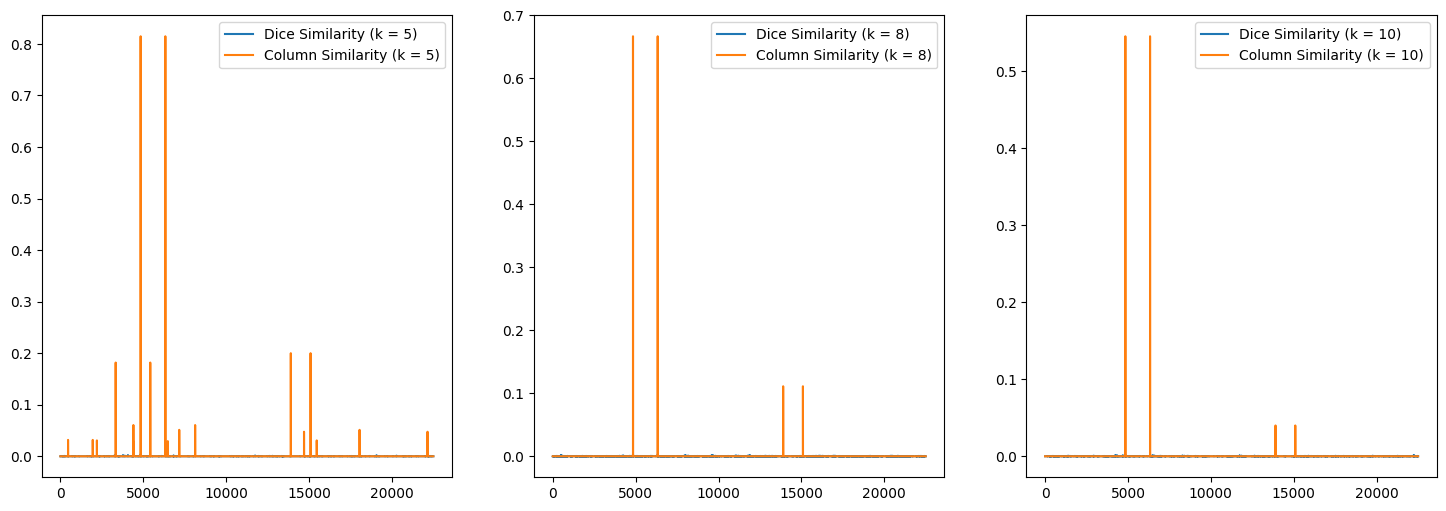

In [48]:
plot_dice_similarity(150, signature_matrix_5_10, signature_matrix_8_10, signature_matrix_10_10, 4, word_shingle_5_df, word_shingle_8_df, word_shingle_10_df)  #10

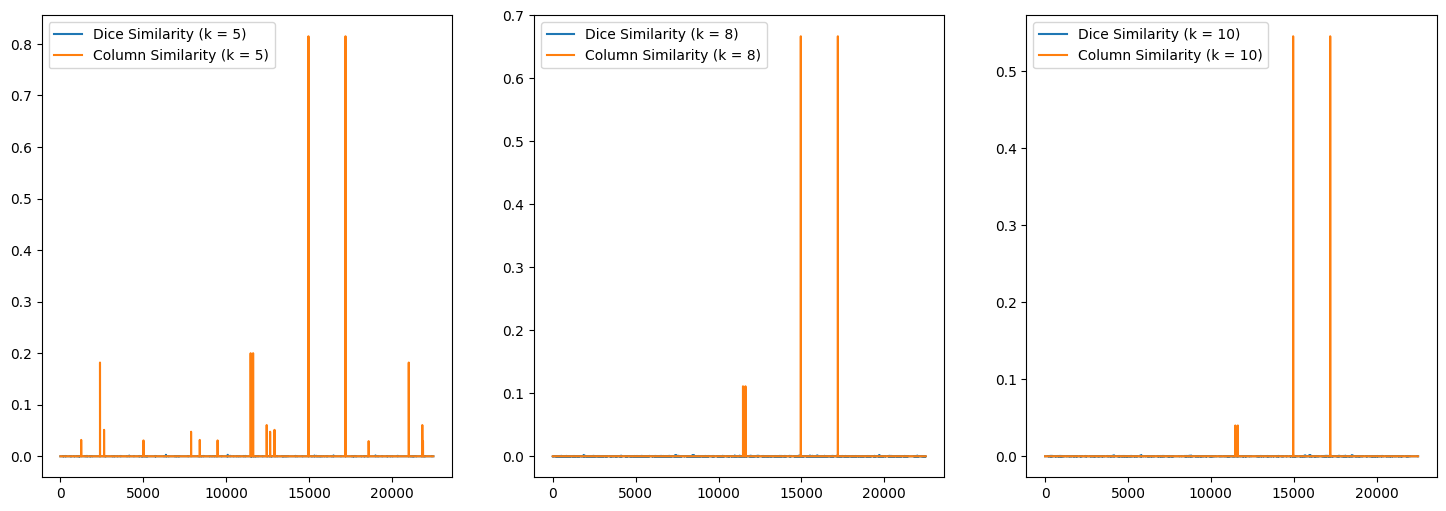

In [49]:
plot_dice_similarity(150, signature_matrix_5_20, signature_matrix_8_10, signature_matrix_10_10, 4, word_shingle_5_df, word_shingle_8_df, word_shingle_10_df)  #20

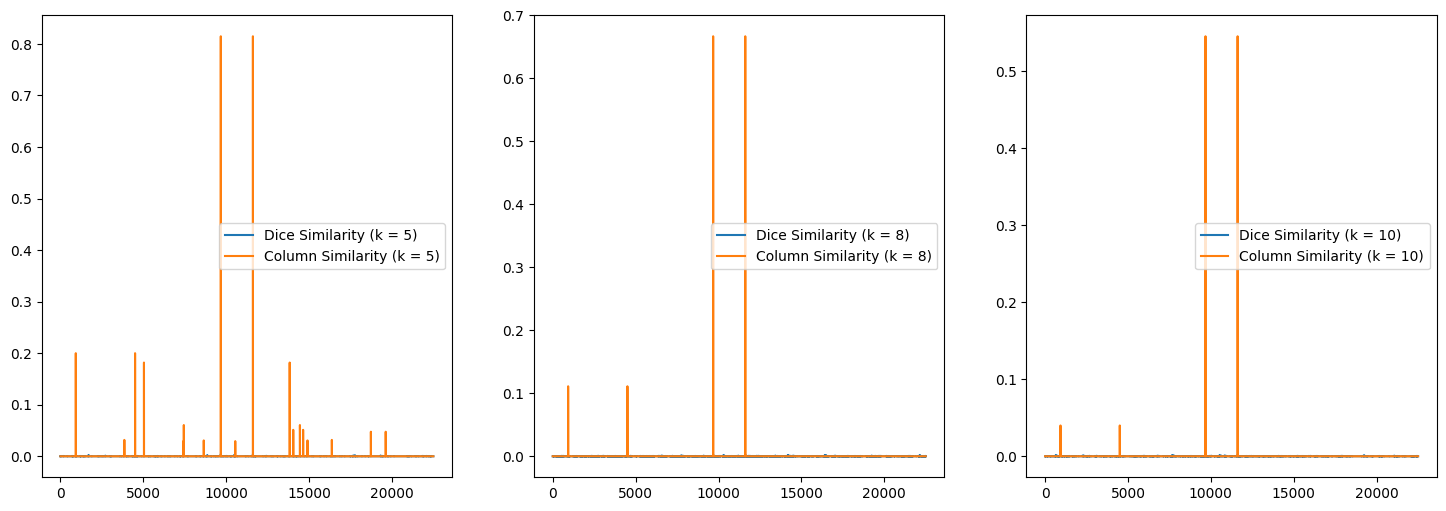

In [50]:
plot_dice_similarity(150, signature_matrix_5_10, signature_matrix_8_10, signature_matrix_10_10, 4, word_shingle_5_df, word_shingle_8_df, word_shingle_10_df)   #30